In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("../")

import utils as ut

In [3]:
meta_file = "/data5/deepro/starrseq/data/meta_data/metadata.json"
all_lib_names = ["input", "control", "atf2", "ctcf", "foxa1", "lef1", "scrt1", "tcf7l2", "16p12.1"]
store_dir = "/data5/deepro/starrseq/main_library/2_quality_control_lib/data/"

In [4]:
def read_and_extract_coverage(cov_bed):
    df = pd.read_csv(cov_bed, sep="\t", header=None)
    roi_depth = df.iloc[:, -4]
    return roi_depth

def get_lib_depth_beds_filepaths(store_dir, lib_short, lib_prefix, lib_reps):
    depth_beds = [ut.get_depth_bed_filepaths(store_dir, lib_short, lib_prefix, lib_rep) for lib_rep in lib_reps.split()]
    return depth_beds

In [5]:
lib_dfs = []

for lib_name in all_lib_names:
    lib_args = ut.create_args(meta_file, lib_name)
    lib_beds = get_lib_depth_beds_filepaths(store_dir, lib_args.library_short, lib_args.library_prefix, lib_args.library_reps)
    lib_df = pd.concat(list(map(read_and_extract_coverage, lib_beds)), axis=1)
    lib_df.columns = [f"{lib_name.upper()} Rep {i}" for i in range(1, len(lib_beds)+1)] 
    lib_dfs.append(lib_df)

In [7]:
meta_df = pd.concat([df for df in lib_dfs], axis=1) 

# Within and between library correlation plot

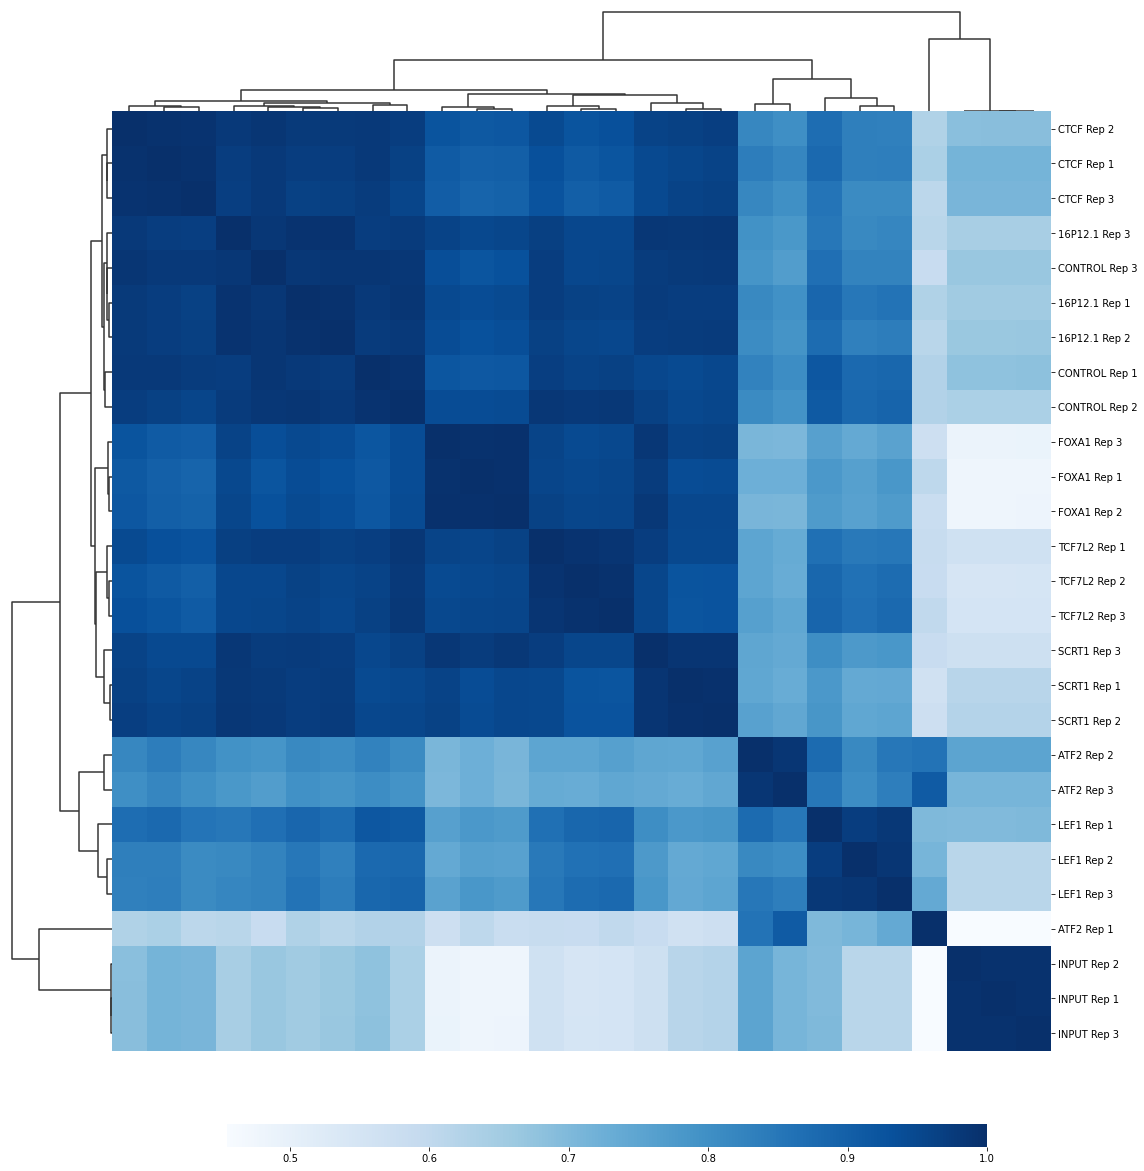

In [16]:
sns_ax = sns.clustermap(
    meta_df.corr(), 
    cmap="Blues", figsize = (16, 16), dendrogram_ratio=0.1, tree_kws={"linewidths": 1.5}, cbar_kws={"orientation": "horizontal"}
    )

sns_ax.ax_heatmap.set_xticks([])
sns_ax.ax_heatmap.set_xticklabels([])
sns_ax.ax_cbar.set_position((0.2, 0.001, 0.66, 0.02))

# Within library correlation

In [34]:
def get_within_replicate_correlation(df):
    corrs = dict()
    for i in range(df.shape[1]):
        for j in range(i+1, df.shape[1]):
            replicates = f"Replicate {i+1} vs {j+1}"
            rep_corr = df.iloc[:, i].corr(df.iloc[:, j])
            corrs[replicates] = round(rep_corr, 4)
    return corrs

In [35]:
data_dict = {
    "library": [],
    "replicates": [],
    "correlation": []
}


for lib_name, lib_df in zip(all_lib_names, lib_dfs):
    corrs = get_within_replicate_correlation(lib_df)
    for r,c in corrs.items():
        data_dict["library"].append(lib_name)
        data_dict["replicates"].append(r)
        data_dict["correlation"].append(c)

df_lib_corr = pd.DataFrame(data_dict)

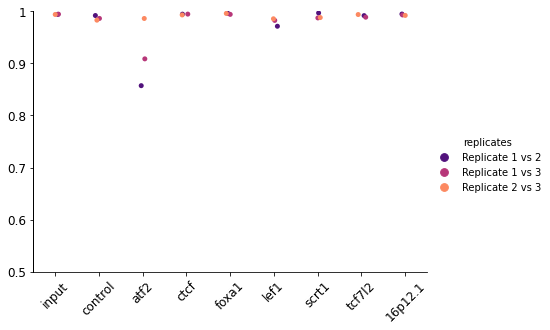

In [36]:
ax = sns.catplot(
    data=df_lib_corr, x="library", y="correlation", hue="replicates", palette="magma", 
    height=5, aspect=1.25, legend=True, 
    order=["input", "control", "atf2", "ctcf", "foxa1", "lef1", "scrt1", "tcf7l2", "16p12.1"]
)
ax.ax.spines["left"].set_linewidth(1)
ax.set_xlabels("")
ax.set_ylabels("", fontsize=14)
ax.set_xticklabels(ax.ax.get_xticklabels(), rotation=45, fontsize=12)
ax.fig.subplots_adjust(top=0.8)
ax.ax.set_ylim([0.5, 1])
ax.set_yticklabels(list(map(str, [0.5, 0.6, 0.7, 0.8, 0.9, 1])), fontsize=12)
# ax.fig.legend(loc=7, prop={"size": 12})
# ax.fig.suptitle("Library Correlation", fontsize=14, fontweight="bold")